In [319]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2
import sqlalchemy
import os
import json
import uuid


In [247]:
conn = psycopg2.connect(
    user="dcat", 
    password="dcat", 
    host="127.0.0.1", 
    port="54320", 
    database="dcat")

In [36]:
conn = psycopg2.connect(
    user="v-oidc-Pau-datacata-8M61CzhFYnWwyGe4RT5T-1573823273", 
    password="A1a-uUUBJHlTN9oyrAQB", 
    host="b27dbvl008.preprod.local", 
    port="5432", 
    database="datacatalog-term")

In [342]:
conn.commit()

In [248]:
cur = conn.cursor()

In [249]:
print ( conn.get_dsn_parameters(),"\n")

{'user': 'dcat', 'dbname': 'dcat', 'host': '127.0.0.1', 'port': '54320', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 



In [250]:
cur.execute("SELECT version();")
record = cur.fetchone()
print("You are connected to - ", record,"\n")

You are connected to -  ('PostgreSQL 12.0 (Debian 12.0-2.pgdg100+1) on x86_64-pc-linux-gnu, compiled by gcc (Debian 8.3.0-6) 8.3.0, 64-bit',) 



# Init

In [343]:
#Relationship description/attributes
cur.execute("delete from tbl_edge_desc")
#Relationships/Edges
cur.execute("delete from tbl_edge")
#Node details table
cur.execute("delete from tbl_node")

conn.commit()

# Get data

In [344]:
xls = pd.ExcelFile("../data/testdata.xlsx")
xls.sheet_names

['Formål GML',
 'Formål',
 'Ark1',
 'data-catalog-backend',
 'data-catalog-policies',
 'Category']

# Populate tables

In [345]:
def get_id(row):
    return row['type'] + '.' + row['name'].upper()

def get_uuid(row):
    return row['type'] + '.' + str(uuid.uuid4()).upper()

### Relationships

In [346]:
relationships = ["has purpose", "based on purpose", "has attribute", "attribute of","belongs to category", "contains concept"]
index = 1
for relationship in relationships:
    insert_query = f"insert into tbl_edge_desc values ({index},'{relationship}')"
    cur.execute(insert_query)
    index += 1
    
conn.commit()

In [347]:
df_links = sqlio.read_sql_query("select * from tbl_edge_desc", conn)
df_links

,id,prop
0,1,has purpose
1,2,based on purpose
2,3,has attribute
3,4,attribute of
4,5,belongs to category
5,6,contains concept


### Processing activities

In [348]:
sheet=xls.sheet_names[1]
df_formål = pd.read_excel(xls, sheet, encoding='latin1')
df_formål = df_formål[['Forslag til endelig formålskode', 'Formålsbeskrivelse']]
df_formål.columns=['code', 'description']
df_formål['name'] = df_formål['code'].apply(lambda x: x.upper())
df_formål = df_formål.append({'name': 'NOT AVAILABLE', 'description': 'Not Available -Verdi mangler'}, ignore_index=True)
df_formål.drop(['code'], axis=1, inplace=True)
df_formål['label'] = 'Processing activity'
df_formål['type'] = 'GDPR.PROCESSING_ACTIVITY'
df_formål['id'] = df_formål.apply(get_id, axis=1)
df_formål.tail()

,description,name,label,type,id
33,Behandle og vurdere rett til uføretrygd som sk...,UFØRETRYGD,Processing activity,GDPR.PROCESSING_ACTIVITY,GDPR.PROCESSING_ACTIVITY.UFØRETRYGD
34,Behandle og vurdere rett til ventelønn som ska...,VENTELØNN,Processing activity,GDPR.PROCESSING_ACTIVITY,GDPR.PROCESSING_ACTIVITY.VENTELØNN
35,Behandle og vurdere rett til ytelser ved yrkes...,YRKESSKADE- OG SYKDOM,Processing activity,GDPR.PROCESSING_ACTIVITY,GDPR.PROCESSING_ACTIVITY.YRKESSKADE- OG SYKDOM
36,Behandle og vurdere rett til ytelser til famil...,YTELSER TIL FAMILIEPLEIER,Processing activity,GDPR.PROCESSING_ACTIVITY,GDPR.PROCESSING_ACTIVITY.YTELSER TIL FAMILIEPL...
37,Not Available -Verdi mangler,NOT AVAILABLE,Processing activity,GDPR.PROCESSING_ACTIVITY,GDPR.PROCESSING_ACTIVITY.NOT AVAILABLE


In [349]:
for index, row in df_formål.iterrows():
    id = index + 1
    jsonb = row.to_json()
    insert_query = f"insert into tbl_node (prop) values ('{jsonb}')"
    cur.execute(insert_query, (jsonb,))
    
conn.commit()

In [350]:
df = sqlio.read_sql_query("select * from tbl_node", conn)
df.tail()

,id,guid,prop,created
33,413,331bbc59-ffc2-4a3b-b883-b8cea64b9159,"{'id': 'GDPR.PROCESSING_ACTIVITY.UFØRETRYGD', ...",2019-11-20 14:54:30.635553
34,414,2c93dc3f-9724-4df9-9403-c8c21116f04b,"{'id': 'GDPR.PROCESSING_ACTIVITY.VENTELØNN', '...",2019-11-20 14:54:30.635553
35,415,c2f178df-4085-42d7-8c86-5673e14f9381,{'id': 'GDPR.PROCESSING_ACTIVITY.YRKESSKADE- O...,2019-11-20 14:54:30.635553
36,416,2dc60483-c209-4ae7-a37d-ba251ea672c1,{'id': 'GDPR.PROCESSING_ACTIVITY.YTELSER TIL F...,2019-11-20 14:54:30.635553
37,417,3cc63349-03d4-4205-95e1-0c40c1e2600a,{'id': 'GDPR.PROCESSING_ACTIVITY.NOT AVAILABLE...,2019-11-20 14:54:30.635553


### Purpose

In [351]:
df_purpose = df_formål.copy()
df_purpose['type'] = 'GDPR.PURPOSE'
df_purpose['label'] = 'Purpose'
df_purpose['id'] = df_purpose.apply(get_id, axis=1)

In [352]:
for i, row in df_purpose.iterrows():
    jsonb = row.to_json()
    insert_query = f"insert into tbl_node (prop) values ('{jsonb}')"
    cur.execute(insert_query, (jsonb,))
    
conn.commit()

In [353]:
df = sqlio.read_sql_query("select * from tbl_node", conn)
df.tail()

,id,guid,prop,created
71,451,e26cc422-329e-4b9b-bae9-dd349b508532,"{'id': 'GDPR.PURPOSE.UFØRETRYGD', 'name': 'UFØ...",2019-11-20 14:55:54.160288
72,452,b5442edf-4566-4045-9fbd-a5f71349f344,"{'id': 'GDPR.PURPOSE.VENTELØNN', 'name': 'VENT...",2019-11-20 14:55:54.160288
73,453,c313ea02-26de-469a-b58e-4e49920e7078,"{'id': 'GDPR.PURPOSE.YRKESSKADE- OG SYKDOM', '...",2019-11-20 14:55:54.160288
74,454,bf8f1743-8f8d-4efb-8662-4730e7d7b054,{'id': 'GDPR.PURPOSE.YTELSER TIL FAMILIEPLEIER...,2019-11-20 14:55:54.160288
75,455,949eb1f9-93af-4a55-996b-aa3e9be67ef3,"{'id': 'GDPR.PURPOSE.NOT AVAILABLE', 'name': '...",2019-11-20 14:55:54.160288


### Legal basis

In [354]:
sheet=xls.sheet_names[4]
df_legal_basis = pd.read_excel(xls, sheet, encoding='latin1')
df_legal_basis = df_legal_basis[['legalBasisDescription']].drop_duplicates()
df_legal_basis.columns=['name']
df_legal_basis = df_legal_basis.append({'name': 'NOT AVAILABLE'}, ignore_index=True)
df_legal_basis['type'] = 'GDPR.LEGAL_BASIS'
df_legal_basis['label'] = 'Legal basis'
df_legal_basis['id'] = df_legal_basis.apply(get_uuid, axis=1)
df_legal_basis.head()

,name,type,label,id
0,Ftrl. § 11-20,GDPR.LEGAL_BASIS,Legal basis,GDPR.LEGAL_BASIS.1581AB0D-93D9-472A-8102-8A80A...
1,"Ftrl. §§ 3-16, 3-24, 3-25, 20-8.",GDPR.LEGAL_BASIS,Legal basis,GDPR.LEGAL_BASIS.A1BAF47B-AE98-4BCE-BA0D-C488B...
2,"Kapittel 3, 19, 20 0g 22",GDPR.LEGAL_BASIS,Legal basis,GDPR.LEGAL_BASIS.3D5069BE-9E34-4AD5-927F-645FE...
3,Ftrl § 3-2 og § 3-3,GDPR.LEGAL_BASIS,Legal basis,GDPR.LEGAL_BASIS.093B1DBD-F2D1-4BCF-853D-B3109...
4,Barnetrygdloven § 9,GDPR.LEGAL_BASIS,Legal basis,GDPR.LEGAL_BASIS.6886D071-74AB-455D-AFCB-A72A4...


In [355]:
for i, row in df_legal_basis.iterrows():
    index = index + 1
    jsonb = row.to_json()
    insert_query = f"insert into tbl_node (prop) values ('{jsonb}')"
    cur.execute(insert_query, (jsonb,))
    
conn.commit()

In [356]:
df = sqlio.read_sql_query("select * from tbl_node", conn)
df.tail()

,id,guid,prop,created
232,612,321717f5-5e7d-4f47-aad5-0f8355684e77,{'id': 'GDPR.LEGAL_BASIS.35DA7B7A-977B-4D06-95...,2019-11-20 14:56:02.478466
233,613,867fda13-1c76-4ae1-9dbf-d55fe87adf96,{'id': 'GDPR.LEGAL_BASIS.D9A2FF2A-F463-4EE6-9D...,2019-11-20 14:56:02.478466
234,614,295bda9b-b134-48dd-8a32-43fcd79d3d44,{'id': 'GDPR.LEGAL_BASIS.97B754AE-65FB-43BF-9E...,2019-11-20 14:56:02.478466
235,615,57c0af94-6d4b-4746-a344-40af9fd99d38,{'id': 'GDPR.LEGAL_BASIS.8BB3C35F-0332-48EF-BB...,2019-11-20 14:56:02.478466
236,616,01b57414-271e-4504-ac70-0dc7f3317ad8,{'id': 'GDPR.LEGAL_BASIS.1CE8D01F-4735-47DB-B6...,2019-11-20 14:56:02.478466


### Information types

In [357]:
sheet=xls.sheet_names[3]

df_concepts = pd.read_excel(xls, sheet, encoding='latin1')
df_concepts = df_concepts[['title', 'description']]
df_concepts.columns=['name', 'description']
df_concepts['name'] = df_concepts['name'].apply(lambda x: x.strip().upper())
df_concepts = df_concepts.append({'name': 'NOT AVAILABLE', 'description': 'Not Available -Verdi mangler'}, ignore_index=True).drop_duplicates()
df_concepts['label'] = 'Information type'
df_concepts['type'] = 'GDPR.INFORMATION_TYPE'
df_concepts['id'] = df_concepts.apply(get_id, axis=1)
df_concepts.head()

,name,description,label,type,id
0,SIVILSTAND,En overordnet kategori som beskriver en person...,Information type,GDPR.INFORMATION_TYPE,GDPR.INFORMATION_TYPE.SIVILSTAND
1,ARBEIDSFORHOLD,"Avtaleforhold hvor den ene part, arbeidstakere...",Information type,GDPR.INFORMATION_TYPE,GDPR.INFORMATION_TYPE.ARBEIDSFORHOLD
2,KJØNN,TODO - mangler i begrepskatalogen og i MFNs be...,Information type,GDPR.INFORMATION_TYPE,GDPR.INFORMATION_TYPE.KJØNN
3,NAVN,I Norge skal alle ha fornavn og ett enkelt ell...,Information type,GDPR.INFORMATION_TYPE,GDPR.INFORMATION_TYPE.NAVN
4,FØDSELSDATO,Datoen personen er født.,Information type,GDPR.INFORMATION_TYPE,GDPR.INFORMATION_TYPE.FØDSELSDATO


In [358]:
df_concepts.iloc[0]['id']

'GDPR.INFORMATION_TYPE.SIVILSTAND'

In [359]:
for i, row in df_concepts.iterrows():
    jsonb = row.to_json()
    insert_query = f"insert into tbl_node (prop) values ('{jsonb}')"
    cur.execute(insert_query, (jsonb,))
    
conn.commit()

In [360]:
df = sqlio.read_sql_query("select * from tbl_node", conn)
df.tail()

,id,guid,prop,created
253,633,1e183c64-4342-4cfb-bc25-362337273821,{'id': 'GDPR.INFORMATION_TYPE.FLYKTNINGSTATUS'...,2019-11-20 14:56:19.974984
254,634,5a16b8aa-3ce7-4214-ac44-1c17136855f8,"{'id': 'GDPR.INFORMATION_TYPE.FORELDREANSVAR',...",2019-11-20 14:56:19.974984
255,635,ceddd42f-2a99-45bd-952f-cbc9f7062687,{'id': 'GDPR.INFORMATION_TYPE.FORSTERFORELDRE'...,2019-11-20 14:56:19.974984
256,636,1998a328-c31f-4837-9b9f-9d6bdff2f180,"{'id': 'GDPR.INFORMATION_TYPE.FULLMAKT', 'name...",2019-11-20 14:56:19.974984
257,637,9569b998-75de-4848-8f22-be6b05179120,"{'id': 'GDPR.INFORMATION_TYPE.NOT AVAILABLE', ...",2019-11-20 14:56:19.974984


### Categories

In [361]:
sheet=xls.sheet_names[3]
df_categories = pd.read_excel(xls, sheet, encoding='latin1')
df_categories = df_categories[['categories']]
df_categories.columns=['name']
df_categories['name'] = df_categories['name'].apply(lambda x: x.strip().upper())
df_categories = df_categories.append({'name': 'NOT AVAILABLE'}, ignore_index=True).drop_duplicates()
df_categories['label'] = 'Information type category'
df_categories['type'] = 'GDPR.INFORMATION_TYPE_CATEGORY'
df_categories['id'] = df_categories.apply(get_id, axis=1)
df_categories.head()

,name,label,type,id
0,PERSONALIA,Information type category,GDPR.INFORMATION_TYPE_CATEGORY,GDPR.INFORMATION_TYPE_CATEGORY.PERSONALIA
1,ARBEIDSFORHOLD,Information type category,GDPR.INFORMATION_TYPE_CATEGORY,GDPR.INFORMATION_TYPE_CATEGORY.ARBEIDSFORHOLD
6,KONTAKTOPPLYSNINGER,Information type category,GDPR.INFORMATION_TYPE_CATEGORY,GDPR.INFORMATION_TYPE_CATEGORY.KONTAKTOPPLYSNI...
9,FAMILIERELASJONER,Information type category,GDPR.INFORMATION_TYPE_CATEGORY,GDPR.INFORMATION_TYPE_CATEGORY.FAMILIERELASJONER
16,FOLKETRYGD,Information type category,GDPR.INFORMATION_TYPE_CATEGORY,GDPR.INFORMATION_TYPE_CATEGORY.FOLKETRYGD


In [362]:
for i, row in df_categories.iterrows():
    index = index + 1
    jsonb = row.to_json()
    insert_query = f"insert into tbl_node (prop) values ('{jsonb}')"
    cur.execute(insert_query, (jsonb,))
    
conn.commit()

### Nodes

In [363]:
df_nodes = sqlio.read_sql_query("select * from tbl_node", conn)
df_nodes['name'] = df_nodes['prop'].apply(lambda x : x['name'])
df_nodes['type'] = df_nodes['prop'].apply(lambda x : x['type'])
df_nodes.head()

,id,guid,prop,created,name,type
0,380,d122642f-261a-4cba-a671-0e340c0a10d9,{'id': 'GDPR.PROCESSING_ACTIVITY.ALDERSPENSJON...,2019-11-20 14:54:30.635553,ALDERSPENSJON,GDPR.PROCESSING_ACTIVITY
1,381,b617d778-376d-4f1b-b923-25f7427c9ffd,{'id': 'GDPR.PROCESSING_ACTIVITY.ARBEIDSAVKLAR...,2019-11-20 14:54:30.635553,ARBEIDSAVKLARINGSPENGER (AAP),GDPR.PROCESSING_ACTIVITY
2,382,1ee33c7b-9fc5-4788-b4f0-6a9161fc4ae2,{'id': 'GDPR.PROCESSING_ACTIVITY.AVTALEFESTET ...,2019-11-20 14:54:30.635553,AVTALEFESTET PENSJON (AFP) FOR PRIVAT SEKTOR,GDPR.PROCESSING_ACTIVITY
3,383,2b0fe3b7-7747-4445-ba4d-01916f0918e9,{'id': 'GDPR.PROCESSING_ACTIVITY.AVTALEFESTET ...,2019-11-20 14:54:30.635553,AVTALEFESTET PENSJON (AFP) FOR STATLIG OG KOMM...,GDPR.PROCESSING_ACTIVITY
4,384,116dc406-b5be-44e9-b076-1fcc25766ab9,"{'id': 'GDPR.PROCESSING_ACTIVITY.BARNEBIDRAG',...",2019-11-20 14:54:30.635553,BARNEBIDRAG,GDPR.PROCESSING_ACTIVITY


### Edges

In [364]:
sheet=xls.sheet_names[3]
df_edges = pd.read_excel(xls, sheet, encoding='latin1')
df_edges = df_edges[['title', 'categories']].drop_duplicates()
df_edges.columns = ['source', 'target']
df_edges['source'] = df_edges['source'].apply(lambda x: x.strip().upper())
df_edges['target'] = df_edges['target'].apply(lambda x: x.strip().upper())
df_edges.drop_duplicates()

df_edges.head()

,source,target
0,SIVILSTAND,PERSONALIA
1,ARBEIDSFORHOLD,ARBEIDSFORHOLD
2,KJØNN,PERSONALIA
3,NAVN,PERSONALIA
4,FØDSELSDATO,PERSONALIA


In [368]:
conn.commit()

In [369]:
df_nodes.loc[((df_nodes['name'] == row['source']) & (df_nodes['type'] == 'GDPR.INFORMATION_TYPE')), 'id']

237    617
Name: id, dtype: int64

In [370]:
cur.execute("delete from tbl_edge")
conn.commit()

for index, row in df_edges.iterrows():
    df_nodes.loc[((df_nodes['name'] == row['source']) & (df_nodes['type'] == 'GDPR.INFORMATION_TYPE')), 'id']
    source_id = df_nodes.loc[((df_nodes['name'] == row['source']) & (df_nodes['type'] == 'GDPR.INFORMATION_TYPE')), 'id'].item()
    target_id = df_nodes.loc[((df_nodes['name'] == row['target']) & (df_nodes['type'] == 'GDPR.INFORMATION_TYPE_CATEGORY')), 'id'].item()
    cur.execute(f"insert into tbl_edge (n1,n2,prop) values ({source_id},{target_id},array[5]);")
    
conn.commit()

In [373]:
df_edges = pd.read_excel(xls, sheet, encoding='latin1')
df_edges = df_edges[['categories', 'title']].drop_duplicates()
df_edges.columns = ['source', 'target']
df_edges['source'] = df_edges['source'].apply(lambda x: x.strip().upper())
df_edges['target'] = df_edges['target'].apply(lambda x: x.strip().upper())
df_edges.drop_duplicates()

df_edges.head()

,source,target
0,PERSONALIA,SIVILSTAND
1,ARBEIDSFORHOLD,ARBEIDSFORHOLD
2,PERSONALIA,KJØNN
3,PERSONALIA,NAVN
4,PERSONALIA,FØDSELSDATO


In [374]:
for index, row in df_edges.iterrows():
    df_nodes.loc[((df_nodes['name'] == row['source']) & (df_nodes['type'] == 'GDPR.INFORMATION_TYPE')), 'id']
    source_id = df_nodes.loc[((df_nodes['name'] == row['source']) & (df_nodes['type'] == 'GDPR.INFORMATION_TYPE_CATEGORY')), 'id'].item()
    target_id = df_nodes.loc[((df_nodes['name'] == row['target']) & (df_nodes['type'] == 'GDPR.INFORMATION_TYPE')), 'id'].item()
    cur.execute(f"insert into tbl_edge (n1,n2,prop) values ({source_id},{target_id},array[6]);")
    
conn.commit()


In [375]:
sql = "select * from tbl_edge"
df = sqlio.read_sql_query(sql, conn)
df.head()

,n1,n2,guid,prop,created
0,617,638,13e8f869-c0fa-4792-a50f-5eddda7c0673,[5],2019-11-20 15:04:48.116982
1,618,639,2af01a2a-e711-4429-89a9-375b52767ce8,[5],2019-11-20 15:04:48.116982
2,619,638,1b8d3e4d-f9c1-4cbc-b7f8-6ca7cab780fe,[5],2019-11-20 15:04:48.116982
3,620,638,85969089-295c-4f19-86ea-22cbc2699bf6,[5],2019-11-20 15:04:48.116982
4,621,638,f923c740-6517-4c68-a532-b6b05bb7df33,[5],2019-11-20 15:04:48.116982


In [376]:
conn.commit()

In [377]:
cur.execute("DROP FUNCTION graph_search1(integer,integer,bigint)")

In [378]:
sql = """
create or replace function graph_search1(      
  IN i_root int,                       -- The node that the search is based on        
  IN i_depth int  default 99999,       -- the tier to search (the depth limit)      
  IN i_limit int8 default 2000000000,  -- limit the number of records returned for each tier      
  OUT o_path int[],                    -- output: path, an array of IDs      
  OUT o_point1 int,                    -- output: point 1 ID      
  OUT o_point2 int,                    -- output: point 2 ID      
  OUT o_link_prop int2[],              -- output: the connection property between the two current points      
  OUT o_link_prop_all text,            -- output: the connection property from the starting node to the current node      
  OUT o_depth int                      -- output: current depth (tier)      
) returns setof record as 
$$
      
declare      
  sql text;      
begin      
sql := format($_$      
WITH RECURSIVE search_graph(        
  n1,     -- point 1        
  n2,     -- point 2        
  prop,   -- current edge property      
  all_prop,  -- properties of all edges  
  depth,  -- current depth, starting from 1         
  path    -- path, stored as an array         
) AS (        
        select n1,n2,prop,all_prop,depth,path from (        
        SELECT                               -- ROOT node query        
          g.n1,                              -- point 1        
          g.n2,                              -- point 2        
          g.prop,                            -- edge property        
      g.prop::text as all_prop,          -- properties of all edges  
          1 depth,                           -- initial depth=1        
          ARRAY[g.n1, g.n2] path             -- initial path        
        FROM tbl_edge AS g         
        WHERE         
          n1 = %s                            -- ROOT node=?        
          limit %s                           -- How many records are limited at each tier?        
        ) t        
      UNION ALL        
        select n1,n2,prop,all_prop,depth,path from (        
        SELECT                               -- recursive clause         
          g.n1,                              -- point 1        
          g.n2,                              -- point 2        
          g.prop,                            -- edge property     
      sg.all_prop || g.prop::text as all_prop,    -- properties of all edges  
          sg.depth + 1 depth,                   -- depth +1        
          sg.path || g.n2 path                 -- Add a new point to the path        
        FROM tbl_edge AS g, search_graph AS sg    -- circular INNER JOIN        
        WHERE         
          g.n1 = sg.n2                       -- recursive JOIN condition        
          AND (g.n2 <> ALL(sg.path))                      -- Prevent loop, determine whether it is a loop and judge if the new point is already in the previous path   
          AND sg.depth <= %s                 -- search depth =?          
          limit %s                           -- How many records are limited at each tier?       
        ) t        
)        
SELECT path as o_path, n1 as o_point1, n2 as o_point2, prop as o_link_prop, all_prop as o_link_prop_all, depth as o_depth      
FROM search_graph;                           -- query a recursive table. You can add LIMIT output or use a cursor       
$_$, i_root, i_limit, i_depth, i_limit      
);      
      
return query execute sql;      
      
end;      

$$
 language plpgsql strict;   
"""

cur.execute(sql)

In [379]:
conn.commit()

In [384]:
%%time
sql = "select * from graph_search1(620)"
df = sqlio.read_sql_query(sql, conn)

CPU times: user 2.69 ms, sys: 0 ns, total: 2.69 ms
Wall time: 3.87 ms


In [387]:
sql = "select * from graph_search1(620)"
df = sqlio.read_sql_query(sql, conn)

In [388]:
df

,o_path,o_point1,o_point2,o_link_prop,o_link_prop_all,o_depth
0,"[620, 638]",620,638,[5],{5},1
1,"[620, 638, 622]",638,622,[6],{5}{6},2
2,"[620, 638, 621]",638,621,[6],{5}{6},2
3,"[620, 638, 619]",638,619,[6],{5}{6},2
4,"[620, 638, 617]",638,617,[6],{5}{6},2


In [389]:
df_edgelist=df[['o_point1','o_point2','o_link_prop','o_depth']].copy()
df_edgelist.columns=['source','target','id','weight']
df_edgelist['id'] = df_edgelist['id'].apply(lambda x: x[0])
df_edgelist = pd.merge(df_edgelist, df_links, on='id', how='left')
df_edgelist = pd.merge(df_edgelist, df_nodes[['id', 'name']], left_on='source', right_on='id')
df_edgelist = pd.merge(df_edgelist, df_nodes[['id', 'name']], left_on='target', right_on='id')
df_edgelist = df_edgelist[['prop', 'name_x', 'name_y','id','id_y', 'weight']]
df_edgelist.columns = ['name', 'source', 'target','target_node_id','source_node_id', 'weight']
df_edgelist

,name,source,target,target_node_id,source_node_id,weight
0,belongs to category,NAVN,PERSONALIA,638,620,1
1,contains concept,PERSONALIA,FØDSELSNUMMER,622,638,2
2,contains concept,PERSONALIA,FØDSELSDATO,621,638,2
3,contains concept,PERSONALIA,KJØNN,619,638,2
4,contains concept,PERSONALIA,SIVILSTAND,617,638,2


In [390]:
#!pip install nx_altair

In [391]:
import altair as alt
alt.renderers.enable('notebook')
alt.themes.enable('opaque')
import networkx as nx
import nx_altair as nxa
import numpy as np

G = nx.from_pandas_edgelist(df_edgelist, 'source', 'target', ['name','target_node_id','source_node_id','weight'])
pos = nx.spring_layout(G)

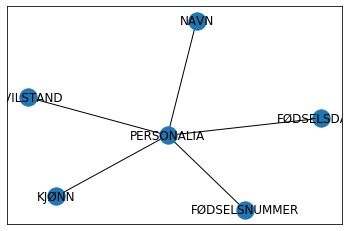

In [392]:
nx.draw_networkx(
    G=G,
    pos=pos
)

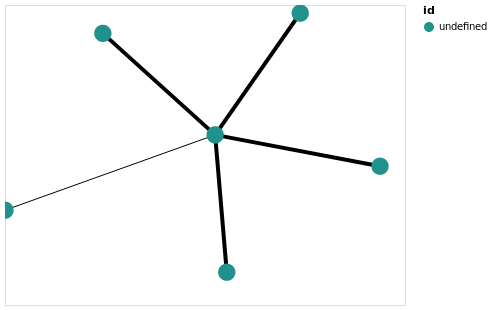

In [393]:
# Compute positions for viz.
pos = nx.spring_layout(G)

viz = nxa.draw_networkx(
    G, pos=pos,
    node_color='id:N',
    cmap='viridis',
    width='weight:N',
    edge_color='black',
    node_tooltip=['weight:N']
)

viz.interactive()